In [1]:
# check version
from platform import python_version
print(python_version())

3.5.6


In [2]:
# # install necessary modules
# import sys
# !{sys.executable} -m pip install pandas_datareader

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 17, 5

import wget
from datetime import date
import os
import numpy as np
import pandas as pd
import datetime as dt
import math
import yfinance as yf
import bs4 as bs
import pickle
import requests

## Шаг 0. Постановка задачи

__Задача:__ Реализовать торговое приложение на языке Python, генерирующее сигнал к покупке или продаже акции.

__Описание проблемы:__ Для реализации стратегии необходимо предсказание среднего значения за будущие 10 дней. Качество предсказывающей модели будем оценивать по RMSE.

__План:__

1) Определение источников данных, настройка системы сбора данных

2) Проверка эффективности торговой стратегии на известных данных

3) Создание дополнительных признаков

4) Выбор модели, настройка параметров; отбор признаков

5) Бэктестинг на данных тех периодов, которые не участвовали в настройке модели (например, используя www.quantopian.com)

6) Подведение итогов

__Критерии успеха:__ Качество предсказаний модели + Положительный торговый результат.

## Шаг 1. Загрузка данных

Загрузим исторические данные о котировках акций компании NVIDIA (NVDA). Посмотрим, как менялась цена акций во времени.

Данные будем брать с Yahoo Finance (https://pypi.org/project/yfinance/)

In [6]:
import yfinance as yf

stock = yf.Ticker("NVDA")
data = stock.history(period="max")

/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '2.6.2' or newer of 'numexpr' (version '2.6.1' currently installed).
  warnings.warn(msg, UserWarning)


In [7]:
data.shape

(5202, 7)

In [8]:
data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-09-17,180.479996,181.240005,178.610001,181.070007,5576200.0,0.0,0.0
2019-09-18,180.789993,181.419998,176.500000,179.979996,6453800.0,0.0,0.0
2019-09-19,180.220001,180.960007,176.509995,176.940002,6136900.0,0.0,0.0
2019-09-20,176.899994,177.850006,172.279999,172.690002,8756100.0,0.0,0.0
2019-09-23,172.699997,176.669998,172.550003,176.029999,4253756.0,0.0,0.0


/Users/mary/anaconda3/envs/py35/lib/python3.5/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


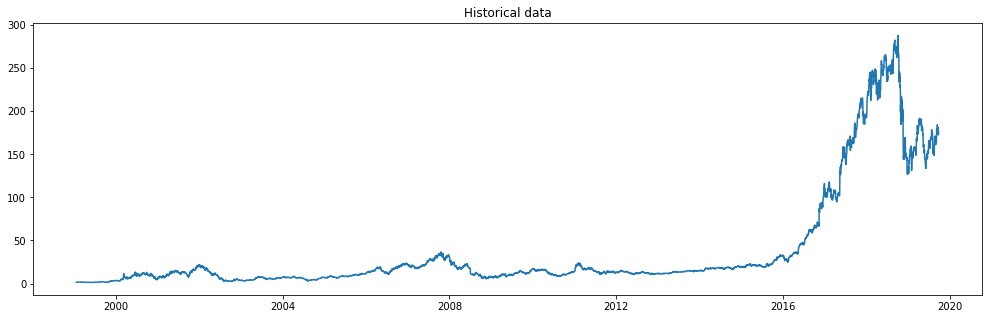

In [9]:
plt.plot(data.Close);
plt.title('Historical data');

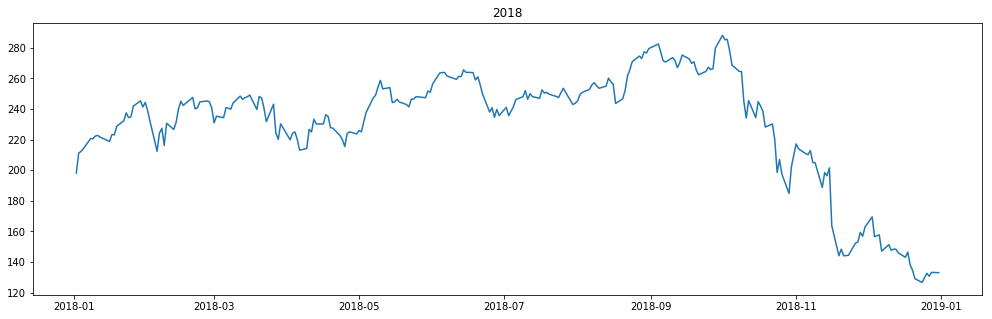

In [10]:
plt.plot(data[(data.index >= '2018-01-01') & (data.index < '2019-01-01')]['Close']);
plt.title('2018');

## Шаг 2. Определение торговой стратегии

Чтобы даже самые точные не оказались предсказания бесполезными, посмотрим на уже известных данных, принесет ли планируемая стратегия прибыль.

Стратегию будем использовать следующую: 
* Вход: если средняя цена последующих 10 дней на 2% больше текущей, то покупаем
* Выход: если средняя цена последующих 10 дней на 1% меньше текущей, то продаем
* Сколько покупаем: покупаем количество соразмерно 1% имеющихся средств
* Сколько продаем: продаем 10% от имеющихся акций


In [119]:
# Проведем проверку на уже известных данных: 
# если бы алгоритм точно предсказывал цену ближайших 5-и дней, то получили ли бы мы профит?
# Найдем кумулятивный доход

def test_historical(start_period, end_period):
    
    price = data[(data.index >= start_period) & (data.index < end_period)]['Close'].copy()
    comis = 0.0002 # 0.02%
    
    money=[]
    stocks=[]
    pnl=[]
    stocks_sum=0
    money_sum=1000000
    n1=10
    n2=10


    for i in range(len(price)-n1):
        cur_price = float(price[i:i+1])
        avg_b = np.average(price[i+1:i+1+n1])
        avg_s = np.average(price[i+1:i+1+n2])

        pnl.append(money_sum + stocks_sum*cur_price)

        if avg_b > 1.02*float(cur_price):
            # buy
            how_many=(money_sum*0.01)/(cur_price*(1+comis))
            if how_many>=1:
                
                money_sum-=cur_price*math.ceil(how_many)*(1+comis)
                stocks_sum+=math.ceil(how_many)

                money.append(money_sum)
                stocks.append(stocks_sum)
                # print('Buying ' + str(math.ceil(how_many)))
                
        elif avg_s < 0.99*float(cur_price):
            # sell
            if stocks_sum>0:
                
                how_many=math.ceil(stocks_sum*0.1)
                
                money_sum+=(1-comis)*cur_price*how_many
                stocks_sum-=how_many

                money.append(money_sum)
                stocks.append(stocks_sum)
                # print('Selling ' + str(math.ceil(how_many)))
    
    print('Number of buy/sell operations: ' + str(len(stocks)))
    print('Profit percent (above initial sum): ' +\
        str(np.round(((stocks[-1]*float(price[-1:]) + money[-1])/1000000 - 1)*100,4)) + '%')
    plt.plot(pnl);
    plt.title('PnL for period: ' + start_period + ' - ' + end_period)

Number of buy/sell operations: 179
Profit percent (above initial sum): 5.4418%


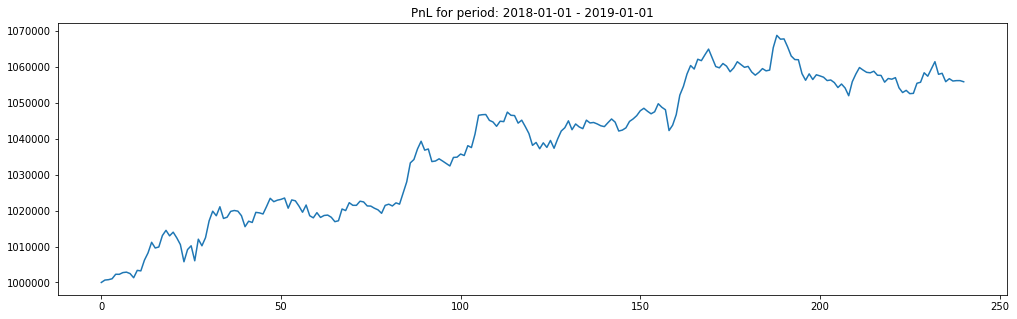

In [120]:
test_historical('2018-01-01', '2019-01-01')

Number of buy/sell operations: 179
Profit percent (above initial sum): 24.5501%


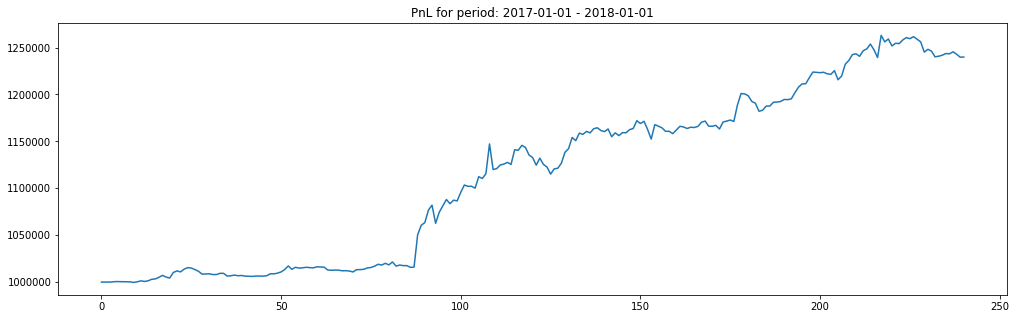

In [121]:
test_historical('2017-01-01', '2018-01-01')

Number of buy/sell operations: 172
Profit percent (above initial sum): 46.9998%


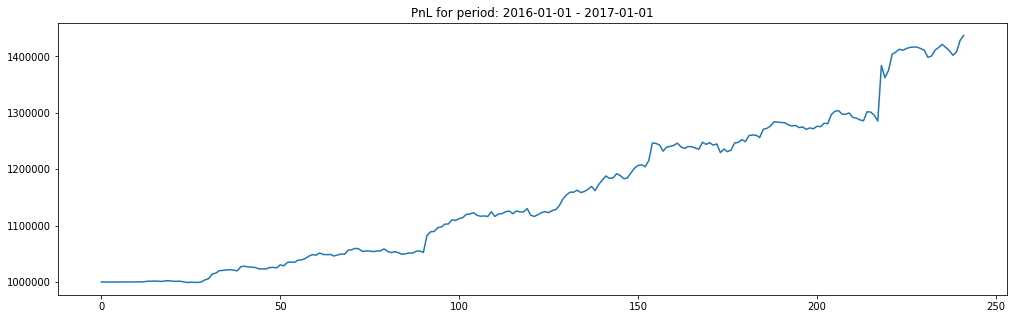

In [122]:
test_historical('2016-01-01', '2017-01-01')

Number of buy/sell operations: 820
Profit percent (above initial sum): 52.1619%


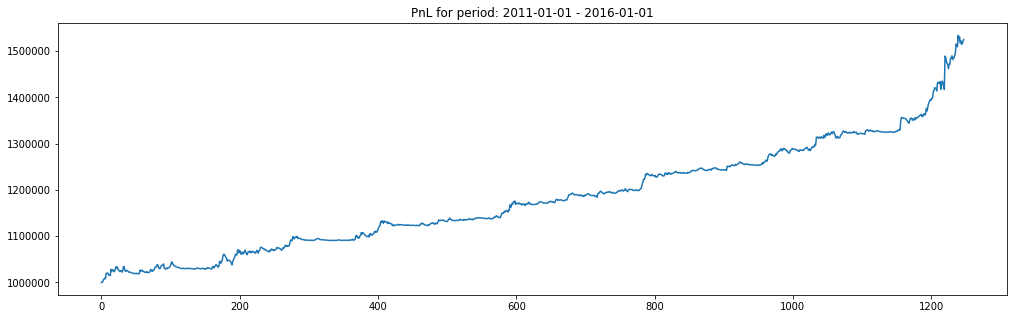

In [123]:
test_historical('2011-01-01', '2016-01-01')

Получили очень неплохие результаты, профит по годам:

* 2018: 5.5%
* 2017: 24.6%
* 2016: 47%

## Шаг 3. Добавление новых признаков

Создадим колонку с целевым значением - среднее за будущие 10 дней

In [15]:
data['Y']=data.Close.rolling(10).mean().shift(-10)

Добавим значения индекса S&P 500 с 1999-01-22 (поскольку NVIDIA на бирже начала котироваться именно в эту дату)

In [16]:
ticker = yf.Ticker("^GSPC")
snp500 = ticker.history(period="max")

In [17]:
snp500_cut = snp500[snp500.index >= '1999-01-22'].reset_index().rename(columns={
    'Open':'Open_snp500', 'High':'High_snp500', 'Low':'Low_snp500', 'Close':'Close_snp500', 
    'Volume':'Volume_snp500'})
snp500_cut = snp500_cut.drop(columns=['Dividends', 'Stock Splits'])
print(snp500_cut.shape)
snp500_cut.head()

(5201, 6)


,Date,Open_snp500,High_snp500,Low_snp500,Close_snp500,Volume_snp500
0,1999-01-22,1235.160034,1236.410034,1217.969971,1225.189941,785900000
1,1999-01-25,1225.189941,1233.979980,1219.459961,1233.979980,723900000
2,1999-01-26,1233.979980,1253.250000,1233.979980,1252.310059,896400000
3,1999-01-27,1252.310059,1262.609985,1242.819946,1243.170044,893800000
4,1999-01-28,1243.170044,1266.400024,1243.170044,1265.369995,848800000


In [18]:
data = pd.merge(data.reset_index(), snp500_cut, on='Date', how='left').set_index('Date').dropna()

Теперь разделим данные на Train, Validation и Test

In [45]:
# Train
df_train = data[data.index < '2016-01-01'].copy()

# Validation
df_valid = data[(data.index >= '2016-01-01') & (data.index < '2018-01-01')].copy()

# Test
df_test = data[data.index >= '2018-01-01'].copy()

Далее нагенерируем признаков

In [46]:
def rsi(data, period):
    data_upside = data.sub(data.shift(1), fill_value=0)
    data_downside = data_upside.copy()
    data_downside[data_upside > 0] = 0
    data_upside[data_upside < 0] = 0
    avg_upside = data_upside.rolling(period).mean()
    avg_downside = - data_downside.rolling(period).mean()
    rsi = 100 - (100 * avg_downside / (avg_downside + avg_upside))
    rsi[avg_downside == 0] = 100
    rsi[(avg_downside == 0) & (avg_upside == 0)] = 0

    return rsi


def add_features(data):
    df = data.copy()
    
    # Shifts
    df['shift1'] = df.Close.shift(1).fillna(0)
    df['shift2'] = df.Close.shift(2).fillna(0)
    df['shift3'] = df.Close.shift(3).fillna(0)
    df['shift5'] = df.Close.shift(5).fillna(0)
    df['shift10'] = df.Close.shift(10).fillna(0)
    df['shift15'] = df.Close.shift(15).fillna(0)
    df['shift30'] = df.Close.shift(30).fillna(0)
    
    # Differences
    df['dif1'] = df.Close.sub(df.Close.shift(2), fill_value=0)
    df['dif3'] = df.Close.sub(df.Close.shift(4), fill_value=0)
    df['dif5'] = df.Close.sub(df.Close.shift(6), fill_value=0)
    df['dif10'] = df.Close.sub(df.Close.shift(11), fill_value=0)
    df['dif15'] = df.Close.sub(df.Close.shift(16), fill_value=0)
    df['dif30'] = df.Close.sub(df.Close.shift(31), fill_value=0)

    # EMAs
    df['ema2'] = df.Close.ewm(2,ignore_na=False,min_periods=0,adjust=True).mean()
    df['ema3'] = df.Close.ewm(3,ignore_na=False,min_periods=0,adjust=True).mean()
    df['ema5'] = df.Close.ewm(5,ignore_na=False,min_periods=0,adjust=True).mean()
    df['ema10'] = df.Close.ewm(10,ignore_na=False,min_periods=0,adjust=True).mean()
    df['ema15'] = df.Close.ewm(15,ignore_na=False,min_periods=0,adjust=True).mean()
    df['ema30'] = df.Close.ewm(30,ignore_na=False,min_periods=0,adjust=True).mean()
    df['ema90'] = df.Close.ewm(90,ignore_na=False,min_periods=0,adjust=True).mean()
    
    # RSI
    df['rsi5'] = rsi(df.Close,5)
    df['rsi10'] = rsi(df.Close,10)
    df['rsi15'] = rsi(df.Close,15)
    df['rsi30'] = rsi(df.Close,30)
    
    df = df.fillna(0)
    print("Any null data : %s"%(df.isnull().values.any()))
    print("Shape: " + str(df.shape))
    
    return df

In [47]:
df_train = add_features(df_train)
df_valid = add_features(df_valid)
df_test = add_features(df_test)

Any null data : False
Shape: (4254, 37)
Any null data : False
Shape: (503, 37)
Any null data : False
Shape: (424, 37)


In [52]:
df_train.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Y,Open_snp500,High_snp500,...,ema3,ema5,ema10,ema15,ema30,ema90,rsi5,rsi10,rsi15,rsi30
Date,,,,,,,,,,,,,,,,,,,,,
1999-01-22,1.612817,1.800019,1.430415,1.512016,67867200.0,0.0,0.0,1.500015,1235.160034,1236.410034,...,1.512016,1.512016,1.512016,1.512016,1.512016,1.512016,0.0,0.0,0.0,0.0
1999-01-25,1.632017,1.689617,1.512015,1.670417,12762000.0,0.0,0.0,1.479855,1225.189941,1233.979980,...,1.602531,1.598416,1.594988,1.593771,1.592515,1.591654,0.0,0.0,0.0,0.0
1999-01-26,1.689618,1.723218,1.516816,1.540816,8580000.0,0.0,0.0,1.466895,1233.979980,1253.250000,...,1.575843,1.575629,1.575185,1.574969,1.574714,1.574520,0.0,0.0,0.0,0.0


In [53]:
# Divide Y from X
x_train, y_train = df_train.drop(columns=['Y']), df_train.Y
x_valid, y_valid = df_valid.drop(columns=['Y']), df_valid.Y
x_test, y_test = df_test.drop(columns=['Y']), df_test.Y

Теперь посмотрим на корреляцию признаков с таргет переменной

In [61]:
corrs = df_train.corr()['Y'].sort_values(ascending=False)
corrs

Y                1.000000
Close            0.991793
Low              0.991279
High             0.990979
Open             0.990231
ema2             0.990097
shift1           0.989644
ema3             0.988957
shift2           0.987508
ema5             0.986525
shift3           0.985354
shift5           0.980992
ema10            0.980052
ema15            0.973296
shift10          0.969371
shift15          0.956661
ema30            0.952626
shift30          0.917142
ema90            0.879301
Low_snp500       0.586015
Close_snp500     0.585740
Open_snp500      0.585395
High_snp500      0.585151
Volume_snp500    0.378910
dif30            0.242636
rsi30            0.224564
dif15            0.176907
rsi15            0.156097
dif10            0.143651
rsi10            0.125525
dif5             0.103224
rsi5             0.094819
dif3             0.083289
dif1             0.057286
Dividends        0.048659
Stock Splits     0.014821
Volume          -0.095639
Name: Y, dtype: float64

## Шаг 4. Выбор модели

Пропишем функцию RMSE для оценки результатов работы моделей и построим бейзлайн модель - линейную регрессию без нормализации

In [124]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

Coefficients: 
 [-1.02982434e-01  9.00597831e-02  1.82824322e-01  8.62823009e-01
  6.33069592e-11 -3.76115201e-01 -6.24125799e-01 -1.85531514e-04
  2.59019062e-03 -9.99671030e-04 -1.14543666e-03  3.35623640e-11
  1.65354397e-01  4.74704595e-01 -1.52237006e-02 -5.74478096e-03
 -5.04349440e-02  4.04855142e-02  2.36708491e-02  3.88119103e-01
  2.31422292e-02  1.40250968e-02 -5.22388505e-02  3.33449756e-02
 -3.40795695e-02 -9.28363482e+00  1.64040938e+01 -1.09265527e+01
  6.18866160e+00 -3.51705258e+00  4.90481805e-01 -4.57041242e-02
  9.93357425e-04 -1.08934134e-03  1.16161630e-03  1.51859728e-03]
Root mean squared error: 6.78
Variance score: 0.99


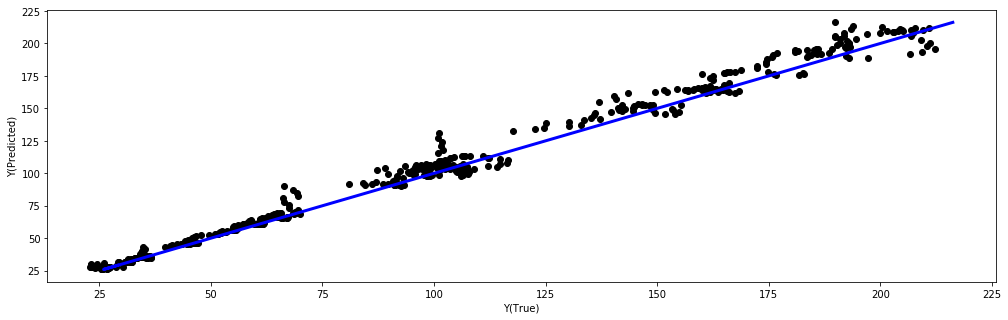

In [125]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr = LinearRegression() # create model
lr.fit(x_train, y_train) # train model
y_pred = lr.predict(x_valid) # predict

# print coeffs and metrics
print('Coefficients: \n', lr.coef_)
print('Root mean squared error: %.2f' % rmse(y_pred, y_valid))
print('Variance score: %.2f' % r2_score(y_pred, y_valid))

# plot results
plt.scatter(y_pred, y_valid,  color='black')
plt.plot(y_valid, y_valid, color='blue', linewidth=3)
plt.xlabel('Y(True)')
plt.ylabel('Y(Predicted)')
plt.show()

Попробуем теперь использовать только те признаки, корреляция которых с таргет переменной >90%

Coefficients: 
 [ 1.53718641e+00  2.54323478e-01  7.40987013e-02 -1.20722681e-01
 -1.23239035e+01  3.27580011e-01  2.05667134e+01  1.83990059e-01
 -1.31709159e+01  2.17328667e-02 -2.60897675e-02  6.25575356e+00
 -2.85082432e+00  3.09091877e-03  1.27226574e-02  2.46066914e-01]
Root mean squared error: 6.39
Variance score: 0.99


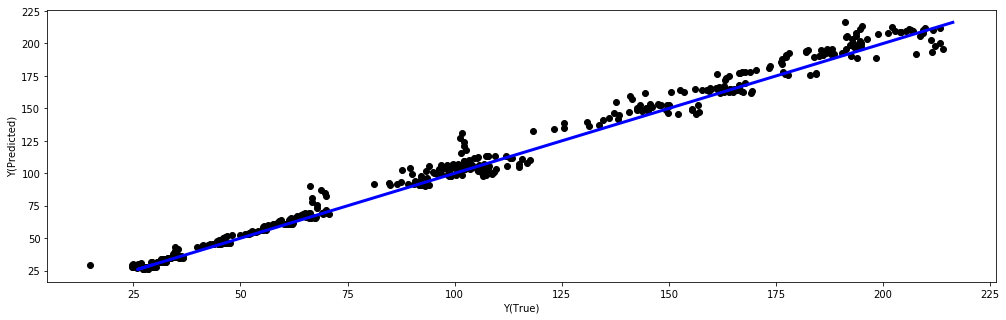

In [126]:
lr = LinearRegression() # create model
lr.fit(x_train[list(corrs[1:17].index)], y_train) # train model
y_pred = lr.predict(x_valid[list(corrs[1:17].index)]) # predict

# print coeffs and metrics
print('Coefficients: \n', lr.coef_)
print('Root mean squared error: %.2f' % rmse(y_pred, y_valid))
print('Variance score: %.2f' % r2_score(y_pred, y_valid))

# plot results
plt.scatter(y_pred, y_valid,  color='black')
plt.plot(y_valid, y_valid, color='blue', linewidth=3)
plt.xlabel('Y(True)')
plt.ylabel('Y(Predicted)')
plt.show()

Код для бэктестинга на www.quantopian.com (после прохождения по ссылке - Research - Algorythms - выбираем любой алгоритм и вставляем в черное окно в левой части экрана необходимый код) выглядит следующим образом:

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

def initialize(context):
    """
    Called once at the start of the algorithm.
    """   
    context.stocks = symbols('NVDA')
    context.n_bars = 366*5

    # Rebalance every day, 1 hour after market open.
    schedule_function(my_trade_func, date_rules.every_day(), time_rules.market_open(hours=1))

    
def get_train_sets(data, context, stock):
    """"Does Feature engineering"""
    close_hist = data.history(stock, 'close', context.n_bars, '1d')
    low_hist = data.history(stock, 'low', context.n_bars, '1d')
    high_hist = data.history(stock, 'high', context.n_bars, '1d')
    open_hist = data.history(stock, 'open', context.n_bars, '1d')

    ema2=np.array(pd.Series(np.ravel(np.array(close_hist))
                                   ).ewm(2,ignore_na=False,min_periods=0,adjust=True).mean())
    ema3=np.array(pd.Series(np.ravel(np.array(close_hist))
                                   ).ewm(3,ignore_na=False,min_periods=0,adjust=True).mean())
    ema5=np.array(pd.Series(np.ravel(np.array(close_hist))
                                   ).ewm(5,ignore_na=False,min_periods=0,adjust=True).mean())
    ema10=np.array(pd.Series(np.ravel(np.array(close_hist))
                                    ).ewm(10,ignore_na=False,min_periods=0,adjust=True).mean())
    ema15=np.array(pd.Series(np.ravel(np.array(close_hist))
                                    ).ewm(15,ignore_na=False,min_periods=0,adjust=True).mean())
    ema30=np.array(pd.Series(np.ravel(np.array(close_hist))
                                    ).ewm(30,ignore_na=False,min_periods=0,adjust=True).mean())
    shift1=np.array(pd.Series(np.ravel(np.array(close_hist))
                                    ).shift(1))
    shift2=np.array(pd.Series(np.ravel(np.array(close_hist))
                                    ).shift(2))
    shift3=np.array(pd.Series(np.ravel(np.array(close_hist))
                                    ).shift(3))
    shift5=np.array(pd.Series(np.ravel(np.array(close_hist))
                                    ).shift(5))
    shift10=np.array(pd.Series(np.ravel(np.array(close_hist))
                                    ).shift(10))
    shift15=np.array(pd.Series(np.ravel(np.array(close_hist))
                                    ).shift(15))
    y_train=np.array(pd.Series(np.ravel(np.array(close_hist))
                                      ).rolling(10).mean().shift(-10))
    x_train = np.c_[np.ravel(np.array(close_hist)),
                       np.ravel(np.array(low_hist)),
                       np.ravel(np.array(high_hist)),
                       np.ravel(np.array(open_hist)),
                       ema2, ema3, ema5, ema10, ema15, ema30,
                       shift1, shift2, shift3, shift5, shift10, shift15
                      ]
    x_train[np.isnan(x_train)] = 0
    
    return x_train, y_train

def my_trade_func(context,data):
    """Execute orders according to our schedule_function() timing."""   

    for stock in context.stocks:   
        
        try:
            x_train, y_train = get_train_sets(data, context, stock)
            x_test = x_train[-1:]
            x_train, y_train = x_train[:-10], y_train[:-10]

            lr = LinearRegression() # create model
            lr.fit(x_train, y_train) # train model
            y_pred = lr.predict(x_test[-1:])[0] # predict
            
            cur_price = data.current(stock, 'price')
            
            print('Prediction ' + str(y_pred) + ', current price ' + str(cur_price))
            
            # Finally trade itself
            if y_pred > 1.02*float(cur_price):
                order_percent(stock,0.01)
            elif y_pred < 0.99*float(cur_price):
                order_target_percent(stock,-0.1)

        except Exception as e:
            print(str(e))

    record('Leverage',context.account.leverage)
    record('Stock price', cur_price)